# Model 1: Multivariate-3-RNN

## RNN

### Import các thư viện cần thiết

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras import optimizers

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

from tensorflow.keras.optimizers import Adam

In [5]:
plt.style.use('ggplot')

### Hàm callback

In [6]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="10Var-hpg-rnn.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"hpg_history.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [8]:
print(df.head)

<bound method NDFrame.head of              open   high    low  close    volume
time                                            
2007-11-16   2.29   2.29   2.29   2.29    248510
2007-11-19   2.17   2.17   2.17   2.17    120480
2007-11-20   2.08   2.08   2.08   2.08     58710
2007-11-21   1.99   2.16   1.99   2.16    728080
2007-11-22   2.16   2.16   2.08   2.16    266040
...           ...    ...    ...    ...       ...
2025-03-14  27.70  27.85  27.55  27.55  18279900
2025-03-17  27.90  28.15  27.75  27.85  19719700
2025-03-18  27.90  28.05  27.60  27.60  18741700
2025-03-19  27.60  27.60  27.10  27.25  37925600
2025-03-20  27.30  27.45  27.05  27.15  25022500

[4322 rows x 5 columns]>


In [9]:
print(df.isnull().sum())

open      0
high      0
low       0
close     0
volume    0
dtype: int64


### Tiền xử lí dữ liệu

In [10]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [11]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.999667
high      0.999857
low       0.999838
close     1.000000
volume    0.799299
Name: close, dtype: float64

In [12]:
#  Tính toán các thống kê mô tả như trung bình (mean), độ lệch chuẩn (std), min, max, phần trăm phân vị (25%, 50%, 75%).
print(df.describe().volume) # Giúp kiểm tra phân bố của Volume, phát hiện các giá trị bất thường (outliers).

count    4.320000e+03
mean     7.877410e+06
std      1.133795e+07
min      5.000000e+01
25%      4.646300e+05
50%      2.422785e+06
75%      1.233620e+07
max      9.967998e+07
Name: volume, dtype: float64


<Axes: >

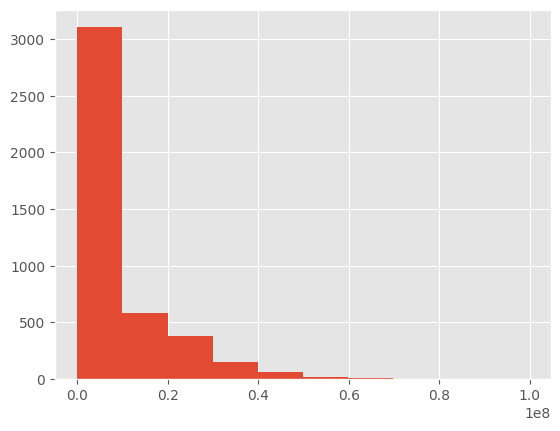

In [13]:
# Vẽ biểu đồ tần suất của Volume
df['volume'].hist(bins=10)

**Phân tích phân bố dữ liệu Volume bằng Histogram**  

🔹 `.hist(bins=10)`  
- Vẽ **biểu đồ histogram** của cột `Volume` với **10 bins (nhóm dữ liệu)**.  
- Giúp trực quan hóa **phân bố dữ liệu**, phát hiện sự **lệch** (skewness) và **giá trị ngoại lai** (outliers).  

**Ý nghĩa của biểu đồ histogram**  

- **Nếu phân bố lệch phải (right-skewed)** → Dữ liệu có nhiều giá trị nhỏ, một số giá trị rất lớn.  
- **Nếu phân bố lệch trái (left-skewed)** → Dữ liệu có nhiều giá trị lớn, một số giá trị rất nhỏ.  
- **Nếu có outliers (điểm nằm xa tập trung chính)** → Có thể cần xử lý như **loại bỏ** hoặc **chuẩn hóa dữ liệu**.  

**Cách xử lý dữ liệu lệch/skewed**  

✅ **Log Transformation** → Dùng `np.log1p(Volume)` để giảm độ lệch.  
✅ **Scaling** → Dùng `MinMaxScaler()` hoặc `StandardScaler()` để chuẩn hóa.  
✅ **Xử lý outliers** → Loại bỏ hoặc thay thế bằng **giá trị trung bình/median**.  


In [14]:
# Bổ sung các chỉ báo kĩ thuật

# Tính CMA10
df['CMA10'] = df['close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['high'] + df['low'] + df['close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['low'].rolling(window=14).min()
high_max = df['high'].rolling(window=14).max()

df['%K'] = 100 * (df['close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [15]:
print(df.head())
df.shape

            open  high   low  close  volume  CMA10  SMA10  SMA50     EMA12  \
time                                                                         
2007-11-16  2.29  2.29  2.29   2.29  248510    NaN    NaN    NaN  2.290000   
2007-11-19  2.17  2.17  2.17   2.17  120480    NaN    NaN    NaN  2.271538   
2007-11-20  2.08  2.08  2.08   2.08   58710    NaN    NaN    NaN  2.242071   
2007-11-21  1.99  2.16  1.99   2.16  728080    NaN    NaN    NaN  2.229445   
2007-11-22  2.16  2.16  2.08   2.16  266040    NaN    NaN    NaN  2.218761   

               EMA26      MACD  RSI  CCI  %K  %D  
time                                              
2007-11-16  2.290000  0.000000  NaN  NaN NaN NaN  
2007-11-19  2.281111 -0.009573  NaN  NaN NaN NaN  
2007-11-20  2.266214 -0.024143  NaN  NaN NaN NaN  
2007-11-21  2.258346 -0.028902  NaN  NaN NaN NaN  
2007-11-22  2.251061 -0.032300  NaN  NaN NaN NaN  


(4320, 15)

## Train model / Hàm **fit_model_2()**

In [16]:
def fit_model_2(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(SimpleRNN(hl[i], activation = 'relu', return_sequences = True))
    model.add(SimpleRNN(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(learning_rate= lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    for layer in model.layers:
        if isinstance(layer, SimpleRNN):
            layer.reset_states() #Đảm bảo mỗi lần huấn luyện không bị ảnh hưởng bởi trạng thái cũ của LSTM.
    return model, history.history['loss'], history.history['val_loss']

###  Bước 1: Đặt Seed để đảm bảo tính tái lập

Giúp đảm bảo mỗi lần chạy chương trình, các giá trị ngẫu nhiên được tạo ra giống nhau, tránh kết quả huấn luyện thay đổi giữa các lần chạy.

In [ ]:
"""
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)
"""

'\nnp.random.seed(1)\ntf.random.set_seed(2)\nrn.seed(3)\n'

### Bước 2: Chuẩn bị dữ liệu huấn luyện (train) và kiểm định (val)

In [ ]:
"""
X_train = []
Y_train = []
X_val = []
Y_val = []

for i in range(timesteps, train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train, Y_train = np.array(X_train, Y_train)

for i in range(timesteps, val.shape[0]):
    X_val.append(val[i-timesteps:i])
    Y_val.append(val[i][0])
X_val, Y_val = np.array(X_val, Y_val)  
"""

'\nX_train = []\nY_train = []\nX_val = []\nY_val = []\n\nfor i in range(timesteps, train.shape[0]):\n    X_train.append(train[i-timesteps:i])\n    Y_train.append(train[i][0])\nX_train, Y_train = np.array(X_train, Y_train)\n\nfor i in range(timesteps, val.shape[0]):\n    X_val.append(val[i-timesteps:i])\n    Y_val.append(val[i][0])\nX_val, Y_val = np.array(X_val, Y_val)  \n'

### Bước 3: Xây dựng mô hình RNN

In [ ]:
"""
# Xây dựng mô hình RNN
model = Sequential()
model.add(SimpleRNN(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))
for i in range(len(hl)-1):
    model.add(SimpleRNN(hl[i], activation='relu', return_sequences= True))
model.add(SimpleRNN(hl[-1], activation='relu'))
model.add(Dense(1))
"""

"\n# Xây dựng mô hình RNN\nmodel = Sequential()\nmodel.add(SimpleRNN(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))\nfor i in range(len(hl)-1):\n    model.add(SimpleRNN(hl[i], activation='relu', return_sequences= True))\nmodel.add(SimpleRNN(hl[-1], activation='relu'))\nmodel.add(Dense(1))\n"

Thêm một lớp **SimpleRNN đầu tiên**:  
-   `X_train.shape[2]`: Số đặc trưng (features).
-   `input_shape = (X_train.shape[1], X_train.shape[2])`: Định dạng đầu vào (timesteps, số đặc trưng).
-   `activation = 'relu'`: Hàm kích hoạt giúp mô hình học phi tuyến tính.
-   `return_sequences = True`: Giữ lại toàn bộ chuỗi đầu ra để sử dụng trong các lớp tiếp theo.

### Bước 4: Biên dịch mô hình

In [ ]:
"""
# Biên dịch
model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')
"""

"\n# Biên dịch\nmodel.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')\n"

### Bước 5: Huấn luyện mô hình

In [ ]:
"""
history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
"""

'\nhistory = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)\n'

**Cấu hình huấn luyện mô hình**

🔹 Tham số trong quá trình huấn luyện  

✅ `epochs = epochs` → Số vòng huấn luyện  
✅ `batch_size = batch` → Kích thước batch  
✅ `validation_data = (X_val, Y_val)` → Dữ liệu kiểm định để theo dõi hiệu suất sau mỗi epoch  
✅ `verbose = 0` → Không hiển thị log huấn luyện (có thể đặt `verbose = 1` để xem tiến trình)  
✅ `shuffle = False` → Không xáo trộn dữ liệu (do chuỗi thời gian có tính thứ tự)  
✅ `callbacks = callbacks_list` → Danh sách callback hỗ trợ huấn luyện  

### Bước 6: Đảm bảo trạng thái không bị ảnh hưởng khi huấn luyện nhiều lần

In [ ]:
"""
for layer in model.layers:
    if isinstance(layer, SimpleRNN):
        layer.reset_states()
"""

'\nfor layer in model.layers:\n    if isinstance(layer, SimpleRNN):\n        layer.reset_states()\n'

### Bước 7: Trả về kết quả

In [ ]:
"""
return model, history.history['train_loss'], history.history['val_loss']
"""

"\nreturn model, history.history['train_loss'], history.history['val_loss']\n"

## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [17]:
param_grid = {
    'timesteps': [30, 40, 50],
    'hl': [[40, 35]],
    'lr': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'num_epochs': [200, 250]
}

In [18]:
from itertools import product # Tích đề-các
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
# Khởi tạo danh sách lưu kết quả
    results = []
    best_score = float('inf') # Ban đầu được đặt là vô cùng lớn
    best_params = None # Lưu bộ siêu tham số có hiệu suất tốt nhất
# Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())
# Lặp qua từng tổ hợp tham số
    for combination in all_combinations:
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

    print(f'Training with param: {params}')
# Huấn luyện với fit.model()
    model, train_loss, val_loss = fit_model_2(train, val, timesteps, hl, lr,  batch_size, num_epochs)
# Đánh giá mô hình với evaluate_model()
    mse, rmse, mape, r2, _, _ = evaluate_model_2(model, test, timesteps)
# Lưu kết quả
    results.append({
        'timesteps': timesteps,
        'hl': hl,
        'lr': lr,
        'batch_size': batch_size,
        'num_epochs': num_epochs,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    })
# Cập nhật bộ siêu tham số tốt nhất nếu RMSE cải thiện
    if rmse < best_score:
        best_score = rmse
        best_params = params

# Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df

## Hàm **Evaluate_model_2()**

In [24]:
"""
# Định nghĩa hàm mean_absolute_percentage_error() (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100"
    """

'\n# Định nghĩa hàm mean_absolute_percentage_error() (MAPE)\ndef mean_absolute_percentage_error(y_true, y_pred):\n    y_true, y_pred = np.array(y_true), np.array(y_pred)\n    return np.mean(np.abs((y_true - y_pred) / y_true))*100"\n    '

In [19]:
def evaluate_model_2(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

## Plot chart (vẽ biểu đồ)

In [20]:
# Plotting the predictions
def plot_data_2(Y_test,Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [21]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [22]:
# Extracting the series
series = df[['close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(4267, 10)
            close   CMA10   SMA10   SMA50      EMA12        RSI        CCI  \
time                                                                         
2025-03-10  27.95  27.860  27.910  26.726  27.664525  66.666667  72.152412   
2025-03-11  28.15  27.840  27.975  26.749  27.739213  68.965517  61.493516   
2025-03-12  27.80  27.815  27.980  26.771  27.748565  63.440860  54.366686   
2025-03-13  27.70  27.785  27.905  26.782  27.741094  63.440860  39.488661   
2025-03-14  27.55  27.705  27.860  26.793  27.711695  47.887324  16.260163   

                   %K         %D      MACD  
time                                        
2025-03-10  75.609756  78.723924  0.419877  
2025-03-11  85.365854  80.790320  0.427503  
2025-03-12  68.292683  76.422764  0.400685  
2025-03-13  40.000000  64.552846  0.367130  
2025-03-14  28.000000  45.430894  0.324692  


In [23]:
series.describe()

,close,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
count,4267.000000,4267.000000,4267.00000,4267.000000,4267.000000,4267.000000,4267.000000,4267.000000,4267.000000,4267.000000
mean,10.025397,10.022310,9.99800,9.880565,9.992086,52.254060,12.008518,53.007353,53.000609,0.041366
std,10.126221,10.118056,10.10649,10.019039,10.097556,17.992688,112.438235,30.851704,29.031483,0.373255
min,0.680000,0.710000,0.71000,0.793800,0.726093,0.000000,-486.486486,0.000000,0.000000,-1.739242
25%,1.780000,1.778000,1.77800,1.760400,1.776499,38.724730,-76.041990,25.730277,26.681097,-0.045488
50%,5.680000,5.725000,5.70500,5.174200,5.719069,52.577320,21.806854,55.445545,55.238095,0.020672
75%,15.415000,15.376000,15.21950,15.065600,15.178271,66.146301,101.156626,80.702355,79.987975,0.119916
max,39.900000,39.285000,39.28500,37.489200,39.090578,100.000000,364.285714,100.000000,100.000000,2.247325


### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [24]:
series.shape

(4267, 10)

In [25]:
n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)

(2987, 10) (640, 10) (640, 10)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [26]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)

# Chuẩn hóa
sc = MinMaxScaler() # Tạo bộ chuẩn hóa MinMaxScaler
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(2987, 10) (640, 10) (640, 10)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [27]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print(results_df)
print("Best parameters:", best_params)
print("Best RMSE score:", best_score)


Training with param: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 1.55522, saving model to 10Var-hpg-rnn.h5



Epoch 2: val_loss improved from 1.55522 to 0.70718, saving model to 10Var-hpg-rnn.h5



Epoch 3: val_loss improved from 0.70718 to 0.29848, saving model to 10Var-hpg-rnn.h5



Epoch 4: val_loss improved from 0.29848 to 0.11666, saving model to 10Var-hpg-rnn.h5



Epoch 5: val_loss improved from 0.11666 to 0.05989, saving model to 10Var-hpg-rnn.h5



Epoch 6: val_loss improved from 0.05989 to 0.04296, saving model to 10Var-hpg-rnn.h5



Epoch 7: val_loss improved from 0.04296 to 0.03588, saving model to 10Var-hpg-rnn.h5



Epoch 8: val_loss improved from 0.03588 to 0.03239, saving model to 10Var-hpg-rnn.h5



Epoch 9: val_loss improved from 0.03239 to 0.03031, saving model to 10Var-hpg-rnn.h5



Epoch 10: val_loss improved from 0.03031 to 0.02851, saving model to 10Var-hpg-rnn.h5



Epoch 11: val_loss improved from 0.02851 to 0.02678, saving model to 10Var-hpg-rnn.h5



Epoch 12: val_loss improved from 0.02678 to 0.02519, saving model to 10Var-hpg-rnn.h5



Epoch 13: val_loss improved from 0.02519 to 0.02382, saving model to 10Var-hpg-rnn.h5



Epoch 14: val_loss improved from 0.02382 to 0.02276, saving model to 10Var-hpg-rnn.h5



Epoch 15: val_loss improved from 0.02276 to 0.02185, saving model to 10Var-hpg-rnn.h5



Epoch 16: val_loss improved from 0.02185 to 0.02094, saving model to 10Var-hpg-rnn.h5



Epoch 17: val_loss improved from 0.02094 to 0.01984, saving model to 10Var-hpg-rnn.h5



Epoch 18: val_loss improved from 0.01984 to 0.01898, saving model to 10Var-hpg-rnn.h5



Epoch 19: val_loss improved from 0.01898 to 0.01766, saving model to 10Var-hpg-rnn.h5



Epoch 20: val_loss improved from 0.01766 to 0.01706, saving model to 10Var-hpg-rnn.h5



Epoch 21: val_loss improved from 0.01706 to 0.01650, saving model to 10Var-hpg-rnn.h5



Epoch 22: val_loss did not improve from 0.01650

Epoch 23: val_loss improved from 0.01650 to 0.01626, saving model to 10Var-hpg-rnn.h5



Epoch 24: val_loss improved from 0.01626 to 0.01578, saving model to 10Var-hpg-rnn.h5



Epoch 25: val_loss improved from 0.01578 to 0.01485, saving model to 10Var-hpg-rnn.h5



Epoch 26: val_loss improved from 0.01485 to 0.01442, saving model to 10Var-hpg-rnn.h5



Epoch 27: val_loss improved from 0.01442 to 0.01424, saving model to 10Var-hpg-rnn.h5



Epoch 28: val_loss improved from 0.01424 to 0.01421, saving model to 10Var-hpg-rnn.h5



Epoch 29: val_loss did not improve from 0.01421

Epoch 30: val_loss did not improve from 0.01421

Epoch 31: val_loss did not improve from 0.01421

Epoch 32: val_loss did not improve from 0.01421

Epoch 33: val_loss did not improve from 0.01421

Epoch 34: val_loss did not improve from 0.01421

Epoch 35: val_loss did not improve from 0.01421

Epoch 36: val_loss did not improve from 0.01421

Epoch 37: val_loss did not improve from 0.01421

Epoch 38: val_loss did not improve from 0.01421

Epoch 39: val_loss did not improve from 0.01421

Epoch 40: val_loss did not improve from 0.01421

Epoch 41: val_loss did not improve from 0.01421

Epoch 42: val_loss did not improve from 0.01421

Epoch 43: val_loss did not improve from 0.01421

Epoch 44: val_loss did not improve from 0.01421

Epoch 45: val_loss did not improve from 0.01421

Epoch 46: val_loss did not improve from 0.01421

Epoch 47: val_loss did not improve from 0.01421

Epoch 48: val_loss did not improve from 0.01421

Epoch 49: val_loss 


Epoch 58: val_loss improved from 0.01410 to 0.01404, saving model to 10Var-hpg-rnn.h5



Epoch 59: val_loss improved from 0.01404 to 0.01392, saving model to 10Var-hpg-rnn.h5



Epoch 60: val_loss improved from 0.01392 to 0.01374, saving model to 10Var-hpg-rnn.h5



Epoch 61: val_loss improved from 0.01374 to 0.01358, saving model to 10Var-hpg-rnn.h5



Epoch 62: val_loss improved from 0.01358 to 0.01348, saving model to 10Var-hpg-rnn.h5



Epoch 63: val_loss improved from 0.01348 to 0.01334, saving model to 10Var-hpg-rnn.h5



Epoch 64: val_loss improved from 0.01334 to 0.01326, saving model to 10Var-hpg-rnn.h5



Epoch 65: val_loss improved from 0.01326 to 0.01311, saving model to 10Var-hpg-rnn.h5



Epoch 66: val_loss improved from 0.01311 to 0.01304, saving model to 10Var-hpg-rnn.h5



Epoch 67: val_loss improved from 0.01304 to 0.01269, saving model to 10Var-hpg-rnn.h5



Epoch 68: val_loss improved from 0.01269 to 0.01266, saving model to 10Var-hpg-rnn.h5



Epoch 69: val_loss improved from 0.01266 to 0.01247, saving model to 10Var-hpg-rnn.h5



Epoch 70: val_loss improved from 0.01247 to 0.01244, saving model to 10Var-hpg-rnn.h5



Epoch 71: val_loss improved from 0.01244 to 0.01229, saving model to 10Var-hpg-rnn.h5



Epoch 72: val_loss improved from 0.01229 to 0.01220, saving model to 10Var-hpg-rnn.h5



Epoch 73: val_loss improved from 0.01220 to 0.01196, saving model to 10Var-hpg-rnn.h5



Epoch 74: val_loss improved from 0.01196 to 0.01184, saving model to 10Var-hpg-rnn.h5



Epoch 75: val_loss improved from 0.01184 to 0.01158, saving model to 10Var-hpg-rnn.h5



Epoch 76: val_loss improved from 0.01158 to 0.01137, saving model to 10Var-hpg-rnn.h5



Epoch 77: val_loss improved from 0.01137 to 0.01117, saving model to 10Var-hpg-rnn.h5



Epoch 78: val_loss improved from 0.01117 to 0.01104, saving model to 10Var-hpg-rnn.h5



Epoch 79: val_loss improved from 0.01104 to 0.01090, saving model to 10Var-hpg-rnn.h5



Epoch 80: val_loss did not improve from 0.01090

Epoch 81: val_loss improved from 0.01090 to 0.01075, saving model to 10Var-hpg-rnn.h5



Epoch 82: val_loss improved from 0.01075 to 0.01072, saving model to 10Var-hpg-rnn.h5



Epoch 83: val_loss improved from 0.01072 to 0.01063, saving model to 10Var-hpg-rnn.h5



Epoch 84: val_loss improved from 0.01063 to 0.01051, saving model to 10Var-hpg-rnn.h5



Epoch 85: val_loss improved from 0.01051 to 0.01045, saving model to 10Var-hpg-rnn.h5



Epoch 86: val_loss improved from 0.01045 to 0.01024, saving model to 10Var-hpg-rnn.h5



Epoch 87: val_loss improved from 0.01024 to 0.01001, saving model to 10Var-hpg-rnn.h5



Epoch 88: val_loss improved from 0.01001 to 0.00969, saving model to 10Var-hpg-rnn.h5



Epoch 89: val_loss improved from 0.00969 to 0.00938, saving model to 10Var-hpg-rnn.h5



Epoch 90: val_loss improved from 0.00938 to 0.00919, saving model to 10Var-hpg-rnn.h5



Epoch 91: val_loss improved from 0.00919 to 0.00909, saving model to 10Var-hpg-rnn.h5



Epoch 92: val_loss did not improve from 0.00909

Epoch 93: val_loss did not improve from 0.00909

Epoch 94: val_loss did not improve from 0.00909

Epoch 95: val_loss did not improve from 0.00909

Epoch 96: val_loss did not improve from 0.00909

Epoch 97: val_loss did not improve from 0.00909

Epoch 98: val_loss did not improve from 0.00909

Epoch 99: val_loss did not improve from 0.00909

Epoch 100: val_loss did not improve from 0.00909

Epoch 101: val_loss did not improve from 0.00909

Epoch 102: val_loss did not improve from 0.00909

Epoch 103: val_loss improved from 0.00909 to 0.00652, saving model to 10Var-hpg-rnn.h5



Epoch 104: val_loss improved from 0.00652 to 0.00647, saving model to 10Var-hpg-rnn.h5



Epoch 105: val_loss did not improve from 0.00647

Epoch 106: val_loss did not improve from 0.00647

Epoch 107: val_loss did not improve from 0.00647

Epoch 108: val_loss did not improve from 0.00647

Epoch 109: val_loss did not improve from 0.00647

Epoch 110: val_loss did not improve from 0.00647

Epoch 111: val_loss did not improve from 0.00647

Epoch 112: val_loss did not improve from 0.00647

Epoch 113: val_loss did not improve from 0.00647

Epoch 114: val_loss did not improve from 0.00647

Epoch 115: val_loss did not improve from 0.00647

Epoch 116: val_loss did not improve from 0.00647

Epoch 117: val_loss did not improve from 0.00647

Epoch 118: val_loss did not improve from 0.00647

Epoch 119: val_loss did not improve from 0.00647

Epoch 120: val_loss did not improve from 0.00647

Epoch 121: val_loss did not improve from 0.00647

Epoch 122: val_loss did not improve from 0.00647

Epoch 123: val_loss did not improve from 0.00647

Epoch 124: val_loss did not improve from 0.00647



Epoch 126: val_loss improved from 0.00645 to 0.00572, saving model to 10Var-hpg-rnn.h5



Epoch 127: val_loss improved from 0.00572 to 0.00485, saving model to 10Var-hpg-rnn.h5



Epoch 128: val_loss improved from 0.00485 to 0.00448, saving model to 10Var-hpg-rnn.h5



Epoch 129: val_loss did not improve from 0.00448

Epoch 130: val_loss did not improve from 0.00448

Epoch 131: val_loss did not improve from 0.00448

Epoch 132: val_loss did not improve from 0.00448

Epoch 133: val_loss did not improve from 0.00448

Epoch 134: val_loss did not improve from 0.00448

Epoch 135: val_loss did not improve from 0.00448

Epoch 136: val_loss did not improve from 0.00448

Epoch 137: val_loss did not improve from 0.00448

Epoch 138: val_loss did not improve from 0.00448

Epoch 139: val_loss did not improve from 0.00448

Epoch 140: val_loss did not improve from 0.00448

Epoch 141: val_loss did not improve from 0.00448

Epoch 142: val_loss did not improve from 0.00448

Epoch 143: val_loss did not improve from 0.00448

Epoch 144: val_loss did not improve from 0.00448

Epoch 145: val_loss did not improve from 0.00448

Epoch 146: val_loss improved from 0.00448 to 0.00445, saving model to 10Var-hpg-rnn.h5



Epoch 147: val_loss improved from 0.00445 to 0.00388, saving model to 10Var-hpg-rnn.h5



Epoch 148: val_loss improved from 0.00388 to 0.00371, saving model to 10Var-hpg-rnn.h5



Epoch 149: val_loss improved from 0.00371 to 0.00370, saving model to 10Var-hpg-rnn.h5



Epoch 150: val_loss did not improve from 0.00370

Epoch 151: val_loss did not improve from 0.00370

Epoch 152: val_loss did not improve from 0.00370

Epoch 153: val_loss did not improve from 0.00370

Epoch 154: val_loss did not improve from 0.00370

Epoch 155: val_loss did not improve from 0.00370

Epoch 156: val_loss did not improve from 0.00370

Epoch 157: val_loss did not improve from 0.00370

Epoch 158: val_loss improved from 0.00370 to 0.00361, saving model to 10Var-hpg-rnn.h5



Epoch 159: val_loss did not improve from 0.00361

Epoch 160: val_loss did not improve from 0.00361

Epoch 161: val_loss did not improve from 0.00361

Epoch 162: val_loss did not improve from 0.00361

Epoch 163: val_loss did not improve from 0.00361

Epoch 164: val_loss did not improve from 0.00361

Epoch 165: val_loss did not improve from 0.00361

Epoch 166: val_loss improved from 0.00361 to 0.00335, saving model to 10Var-hpg-rnn.h5



Epoch 167: val_loss improved from 0.00335 to 0.00326, saving model to 10Var-hpg-rnn.h5



Epoch 168: val_loss improved from 0.00326 to 0.00323, saving model to 10Var-hpg-rnn.h5



Epoch 169: val_loss did not improve from 0.00323

Epoch 170: val_loss did not improve from 0.00323

Epoch 171: val_loss did not improve from 0.00323

Epoch 172: val_loss did not improve from 0.00323

Epoch 173: val_loss did not improve from 0.00323

Epoch 174: val_loss did not improve from 0.00323

Epoch 175: val_loss did not improve from 0.00323

Epoch 176: val_loss did not improve from 0.00323

Epoch 177: val_loss did not improve from 0.00323

Epoch 178: val_loss did not improve from 0.00323

Epoch 179: val_loss did not improve from 0.00323

Epoch 180: val_loss did not improve from 0.00323

Epoch 181: val_loss did not improve from 0.00323

Epoch 182: val_loss did not improve from 0.00323

Epoch 183: val_loss did not improve from 0.00323

Epoch 184: val_loss did not improve from 0.00323

Epoch 185: val_loss did not improve from 0.00323

Epoch 186: val_loss did not improve from 0.00323

Epoch 187: val_loss improved from 0.00323 to 0.00303, saving model to 10Var-hpg-rnn.h5



Epoch 188: val_loss improved from 0.00303 to 0.00302, saving model to 10Var-hpg-rnn.h5



Epoch 189: val_loss did not improve from 0.00302

Epoch 190: val_loss did not improve from 0.00302

Epoch 191: val_loss did not improve from 0.00302

Epoch 192: val_loss did not improve from 0.00302

Epoch 193: val_loss did not improve from 0.00302

Epoch 194: val_loss did not improve from 0.00302

Epoch 195: val_loss did not improve from 0.00302

Epoch 196: val_loss did not improve from 0.00302

Epoch 197: val_loss did not improve from 0.00302

Epoch 198: val_loss did not improve from 0.00302

Epoch 199: val_loss did not improve from 0.00302

Epoch 200: val_loss did not improve from 0.00302

Epoch 201: val_loss did not improve from 0.00302

Epoch 202: val_loss did not improve from 0.00302

Epoch 203: val_loss did not improve from 0.00302

Epoch 204: val_loss did not improve from 0.00302

Epoch 205: val_loss did not improve from 0.00302

Epoch 206: val_loss did not improve from 0.00302

Epoch 207: val_loss improved from 0.00302 to 0.00292, saving model to 10Var-hpg-rnn.h5



Epoch 208: val_loss did not improve from 0.00292

Epoch 209: val_loss did not improve from 0.00292

Epoch 210: val_loss did not improve from 0.00292

Epoch 211: val_loss did not improve from 0.00292

Epoch 212: val_loss did not improve from 0.00292

Epoch 213: val_loss did not improve from 0.00292

Epoch 214: val_loss did not improve from 0.00292

Epoch 215: val_loss did not improve from 0.00292

Epoch 216: val_loss did not improve from 0.00292

Epoch 217: val_loss did not improve from 0.00292

Epoch 218: val_loss did not improve from 0.00292

Epoch 219: val_loss did not improve from 0.00292

Epoch 220: val_loss did not improve from 0.00292

Epoch 221: val_loss did not improve from 0.00292

Epoch 222: val_loss did not improve from 0.00292

Epoch 223: val_loss did not improve from 0.00292

Epoch 224: val_loss did not improve from 0.00292

Epoch 225: val_loss did not improve from 0.00292

Epoch 226: val_loss improved from 0.00292 to 0.00281, saving model to 10Var-hpg-rnn.h5



Epoch 227: val_loss improved from 0.00281 to 0.00280, saving model to 10Var-hpg-rnn.h5



Epoch 228: val_loss did not improve from 0.00280

Epoch 229: val_loss did not improve from 0.00280

Epoch 230: val_loss did not improve from 0.00280

Epoch 231: val_loss did not improve from 0.00280

Epoch 232: val_loss did not improve from 0.00280

Epoch 233: val_loss did not improve from 0.00280

Epoch 234: val_loss did not improve from 0.00280

Epoch 235: val_loss did not improve from 0.00280

Epoch 236: val_loss did not improve from 0.00280

Epoch 237: val_loss did not improve from 0.00280

Epoch 238: val_loss improved from 0.00280 to 0.00279, saving model to 10Var-hpg-rnn.h5



Epoch 239: val_loss did not improve from 0.00279

Epoch 240: val_loss did not improve from 0.00279

Epoch 241: val_loss did not improve from 0.00279

Epoch 242: val_loss did not improve from 0.00279

Epoch 243: val_loss did not improve from 0.00279

Epoch 244: val_loss did not improve from 0.00279

Epoch 245: val_loss did not improve from 0.00279

Epoch 246: val_loss did not improve from 0.00279

Epoch 247: val_loss improved from 0.00279 to 0.00275, saving model to 10Var-hpg-rnn.h5



Epoch 248: val_loss did not improve from 0.00275

Epoch 249: val_loss did not improve from 0.00275

Epoch 250: val_loss did not improve from 0.00275
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
   timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0         50  [40, 35]  0.0001          64         250  0.002294  0.047899   

       MAPE        R²  
0  0.023111  0.970069  
Best parameters: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}
Best RMSE score: 0.0478987837599279


### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [28]:
timesteps = 50
hl = [40, 35]
lr = 0.0001
batch_size = 64
num_epochs = 250

model, train_error, val_error = fit_model_2(train, val, timesteps, hl, lr, batch_size, num_epochs)

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00275

Epoch 2: val_loss did not improve from 0.00275

Epoch 3: val_loss did not improve from 0.00275

Epoch 4: val_loss did not improve from 0.00275

Epoch 5: val_loss did not improve from 0.00275

Epoch 6: val_loss did not improve from 0.00275

Epoch 7: val_loss did not improve from 0.00275

Epoch 8: val_loss did not improve from 0.00275

Epoch 9: val_loss did not improve from 0.00275

Epoch 10: val_loss did not improve from 0.00275

Epoch 11: val_loss did not improve from 0.00275

Epoch 12: val_loss did not improve from 0.00275

Epoch 13: val_loss did not improve from 0.00275

Epoch 14: val_loss did not improve from 0.00275

Epoch 15: val_loss did not improve from 0.00275

Epoch 16: val_loss did not improve from 0.00275

Epoch 17: val_loss did not improve from 0.00275

Epoch 18: val_loss did not improve from 0.00275

Epoch 19: val_loss did not improve from 0.00275

Epoch 20: val_loss did not improve from 0.00275

Epoch 21: val_loss did not i

### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

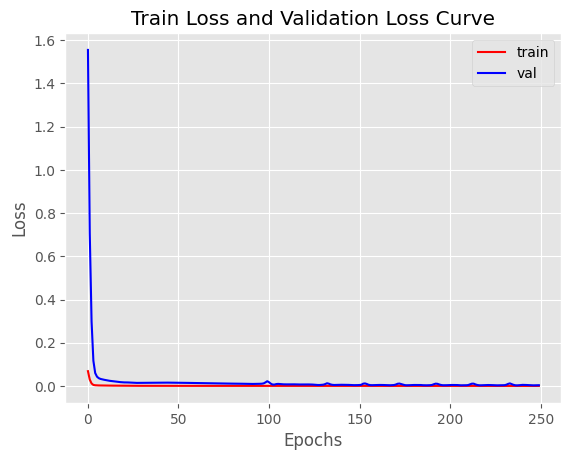

In [29]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [30]:
mse, rmse, mape, r2, true, predicted = evaluate_model_2(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In [31]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.0022942934856803325
RMSE = 0.0478987837599279
MAPE = 0.023111373786061293
R-Squared Score = 0.970069153146253


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

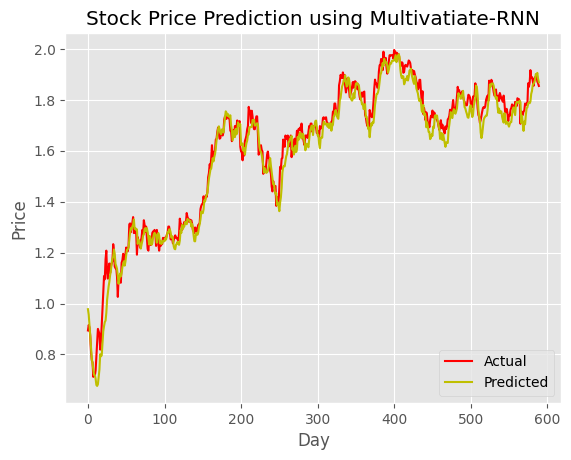

In [32]:
plot_data_2(true, predicted)

In [33]:
# Save a model
model.save('10VAR-hpg-rnn.keras')

In [ ]:
del model

# Model 2: Multivariate-3-GRU

## GRU

### Import các thư viện cần thiết

In [33]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

In [34]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras import optimizers

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

from tensorflow.keras.optimizers import Adam

In [37]:
plt.style.use('ggplot')

### Hàm callback

In [38]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="10Var-hpg-gru.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"hpg_history.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [40]:
df.head()

,open,high,low,close,volume
time,,,,,
2007-11-16,2.29,2.29,2.29,2.29,248510
2007-11-19,2.17,2.17,2.17,2.17,120480
2007-11-20,2.08,2.08,2.08,2.08,58710
2007-11-21,1.99,2.16,1.99,2.16,728080
2007-11-22,2.16,2.16,2.08,2.16,266040


In [41]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

### Tiền xử lí dữ liệu

In [42]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [43]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.999667
high      0.999857
low       0.999838
close     1.000000
volume    0.799299
Name: close, dtype: float64

In [44]:
print(df.describe().volume) 

count    4.320000e+03
mean     7.877410e+06
std      1.133795e+07
min      5.000000e+01
25%      4.646300e+05
50%      2.422785e+06
75%      1.233620e+07
max      9.967998e+07
Name: volume, dtype: float64


<Axes: >

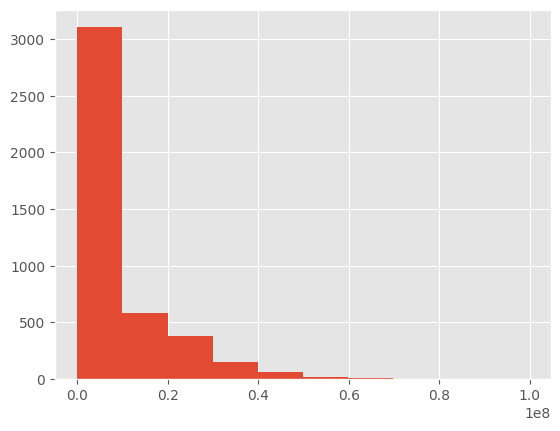

In [45]:
df['volume'].hist(bins= 10)

In [46]:
# Bổ sung các chỉ báo kĩ thuật

# Tính CMA10
df['CMA10'] = df['close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['high'] + df['low'] + df['close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['low'].rolling(window=14).min()
high_max = df['high'].rolling(window=14).max()

df['%K'] = 100 * (df['close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [47]:
print(df.head())
df.shape

            open  high   low  close  volume  CMA10  SMA10  SMA50     EMA12  \
time                                                                         
2007-11-16  2.29  2.29  2.29   2.29  248510    NaN    NaN    NaN  2.290000   
2007-11-19  2.17  2.17  2.17   2.17  120480    NaN    NaN    NaN  2.271538   
2007-11-20  2.08  2.08  2.08   2.08   58710    NaN    NaN    NaN  2.242071   
2007-11-21  1.99  2.16  1.99   2.16  728080    NaN    NaN    NaN  2.229445   
2007-11-22  2.16  2.16  2.08   2.16  266040    NaN    NaN    NaN  2.218761   

               EMA26      MACD  RSI  CCI  %K  %D  
time                                              
2007-11-16  2.290000  0.000000  NaN  NaN NaN NaN  
2007-11-19  2.281111 -0.009573  NaN  NaN NaN NaN  
2007-11-20  2.266214 -0.024143  NaN  NaN NaN NaN  
2007-11-21  2.258346 -0.028902  NaN  NaN NaN NaN  
2007-11-22  2.251061 -0.032300  NaN  NaN NaN NaN  


(4320, 15)

## Train model / Hàm **fit_model_3()**

In [48]:
def fit_model_3(train, val, timesteps, hl, lr, batch, epochs):
    """
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)
    """
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Thêm các lớp vào mô hình
    model = Sequential()
    model.add(GRU(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation= 'relu', return_sequences= True))
    for i in range(len(hl)-1):
        model.add(GRU(hl[i], activation='relu', return_sequences= True))
    model.add(GRU(hl[-1], activation='relu'))
    model.add(Dense(1))

    # Biên dịch
    model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')

    # Huấn luyện dữ liệu
    history = model.fit(X_train, Y_train, epochs= epochs, batch_size= batch, validation_data= (X_val, Y_val), verbose= 0, shuffle= False, callbacks= callbacks_list)
    
    # Đặt lại trạng thái
    for layer in model.layers:
        if isinstance(layer, GRU):
            layer.reset_states()
    
    return model, history.history['loss'], history.history['val_loss']

## Hàm **Evaluate_model_3()**

In [49]:
def evaluate_model_3(model, test, timesteps):
    """
    np.random.seed(1)
    tf.random.set_seed(2)
    """
    X_test = []
    Y_test = []

    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test= np.array(X_test), np.array(Y_test)

    # Các chỉ số đánh giá
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)

    return mse, rmse, mape, r2, Y_test, Y_hat


## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [50]:
param_grid = {
    'timesteps': [30, 40, 50],
    'hl': [[40, 35]],
    'lr': [1e-4, 1e-3],
    'batch_size': [32, 64],
    'num_epochs': [200, 250]
}

In [51]:
# Hàm grid search
def grid_search_rnn(train, val, test, param_grid):
    results = []
    best_score = float('inf')
    best_params = None

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*(param_grid.values())))
    param_names = param_grid.keys()

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f'Training with params: {params}')

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_3(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'mse': mse,
            'rmse': rmse,
            'mape': mape,
            'r2': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

        # Trả về kết quả
        results_df = pd.DataFrame(results)
        return best_params, best_score, results_df


## Plot chart (vẽ biểu đồ)

In [52]:
# Plotting the predictions
def plot_data_3(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [53]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [54]:
# Extracting the series
series = df[['close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(4267, 10)
            close   CMA10   SMA10   SMA50      EMA12        RSI        CCI  \
time                                                                         
2025-03-10  27.95  27.860  27.910  26.726  27.664525  66.666667  72.152412   
2025-03-11  28.15  27.840  27.975  26.749  27.739213  68.965517  61.493516   
2025-03-12  27.80  27.815  27.980  26.771  27.748565  63.440860  54.366686   
2025-03-13  27.70  27.785  27.905  26.782  27.741094  63.440860  39.488661   
2025-03-14  27.55  27.705  27.860  26.793  27.711695  47.887324  16.260163   

                   %K         %D      MACD  
time                                        
2025-03-10  75.609756  78.723924  0.419877  
2025-03-11  85.365854  80.790320  0.427503  
2025-03-12  68.292683  76.422764  0.400685  
2025-03-13  40.000000  64.552846  0.367130  
2025-03-14  28.000000  45.430894  0.324692  


### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [55]:
series.shape

(4267, 10)

In [56]:
n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)

(2987, 10) (640, 10) (640, 10)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [57]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(2987, 10) (640, 10) (640, 10)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [58]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print(results_df)
print("Best parameters:", best_params)
print("Best RMSE score:", best_score)

Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 2.50771, saving model to 10Var-hpg-gru.h5



Epoch 2: val_loss improved from 2.50771 to 2.09337, saving model to 10Var-hpg-gru.h5



Epoch 3: val_loss improved from 2.09337 to 1.71586, saving model to 10Var-hpg-gru.h5



Epoch 4: val_loss improved from 1.71586 to 1.39341, saving model to 10Var-hpg-gru.h5



Epoch 5: val_loss improved from 1.39341 to 1.16265, saving model to 10Var-hpg-gru.h5



Epoch 6: val_loss improved from 1.16265 to 0.94984, saving model to 10Var-hpg-gru.h5



Epoch 7: val_loss improved from 0.94984 to 0.74114, saving model to 10Var-hpg-gru.h5



Epoch 8: val_loss improved from 0.74114 to 0.52979, saving model to 10Var-hpg-gru.h5



Epoch 9: val_loss improved from 0.52979 to 0.37024, saving model to 10Var-hpg-gru.h5



Epoch 10: val_loss improved from 0.37024 to 0.28262, saving model to 10Var-hpg-gru.h5



Epoch 11: val_loss improved from 0.28262 to 0.24039, saving model to 10Var-hpg-gru.h5



Epoch 12: val_loss improved from 0.24039 to 0.22075, saving model to 10Var-hpg-gru.h5



Epoch 13: val_loss improved from 0.22075 to 0.20906, saving model to 10Var-hpg-gru.h5



Epoch 14: val_loss improved from 0.20906 to 0.20132, saving model to 10Var-hpg-gru.h5



Epoch 15: val_loss improved from 0.20132 to 0.19559, saving model to 10Var-hpg-gru.h5



Epoch 16: val_loss improved from 0.19559 to 0.19129, saving model to 10Var-hpg-gru.h5



Epoch 17: val_loss improved from 0.19129 to 0.18773, saving model to 10Var-hpg-gru.h5



Epoch 18: val_loss improved from 0.18773 to 0.18468, saving model to 10Var-hpg-gru.h5



Epoch 19: val_loss improved from 0.18468 to 0.18160, saving model to 10Var-hpg-gru.h5



Epoch 20: val_loss improved from 0.18160 to 0.17886, saving model to 10Var-hpg-gru.h5



Epoch 21: val_loss improved from 0.17886 to 0.17635, saving model to 10Var-hpg-gru.h5



Epoch 22: val_loss improved from 0.17635 to 0.17387, saving model to 10Var-hpg-gru.h5



Epoch 23: val_loss improved from 0.17387 to 0.17168, saving model to 10Var-hpg-gru.h5



Epoch 24: val_loss improved from 0.17168 to 0.16997, saving model to 10Var-hpg-gru.h5



Epoch 25: val_loss improved from 0.16997 to 0.16862, saving model to 10Var-hpg-gru.h5



Epoch 26: val_loss improved from 0.16862 to 0.16756, saving model to 10Var-hpg-gru.h5



Epoch 27: val_loss improved from 0.16756 to 0.16640, saving model to 10Var-hpg-gru.h5



Epoch 28: val_loss improved from 0.16640 to 0.16528, saving model to 10Var-hpg-gru.h5



Epoch 29: val_loss improved from 0.16528 to 0.16445, saving model to 10Var-hpg-gru.h5



Epoch 30: val_loss improved from 0.16445 to 0.16362, saving model to 10Var-hpg-gru.h5



Epoch 31: val_loss improved from 0.16362 to 0.16287, saving model to 10Var-hpg-gru.h5



Epoch 32: val_loss improved from 0.16287 to 0.16214, saving model to 10Var-hpg-gru.h5



Epoch 33: val_loss improved from 0.16214 to 0.16126, saving model to 10Var-hpg-gru.h5



Epoch 34: val_loss improved from 0.16126 to 0.16070, saving model to 10Var-hpg-gru.h5



Epoch 35: val_loss improved from 0.16070 to 0.15985, saving model to 10Var-hpg-gru.h5



Epoch 36: val_loss improved from 0.15985 to 0.15923, saving model to 10Var-hpg-gru.h5



Epoch 37: val_loss improved from 0.15923 to 0.15846, saving model to 10Var-hpg-gru.h5



Epoch 38: val_loss improved from 0.15846 to 0.15773, saving model to 10Var-hpg-gru.h5



Epoch 39: val_loss improved from 0.15773 to 0.15687, saving model to 10Var-hpg-gru.h5



Epoch 40: val_loss improved from 0.15687 to 0.15603, saving model to 10Var-hpg-gru.h5



Epoch 41: val_loss improved from 0.15603 to 0.15511, saving model to 10Var-hpg-gru.h5



Epoch 42: val_loss improved from 0.15511 to 0.15436, saving model to 10Var-hpg-gru.h5



Epoch 43: val_loss improved from 0.15436 to 0.15372, saving model to 10Var-hpg-gru.h5



Epoch 44: val_loss improved from 0.15372 to 0.15265, saving model to 10Var-hpg-gru.h5



Epoch 45: val_loss improved from 0.15265 to 0.15253, saving model to 10Var-hpg-gru.h5



Epoch 46: val_loss improved from 0.15253 to 0.15070, saving model to 10Var-hpg-gru.h5



Epoch 47: val_loss did not improve from 0.15070

Epoch 48: val_loss improved from 0.15070 to 0.14893, saving model to 10Var-hpg-gru.h5



Epoch 49: val_loss did not improve from 0.14893

Epoch 50: val_loss improved from 0.14893 to 0.14746, saving model to 10Var-hpg-gru.h5



Epoch 51: val_loss did not improve from 0.14746

Epoch 52: val_loss improved from 0.14746 to 0.14561, saving model to 10Var-hpg-gru.h5



Epoch 53: val_loss did not improve from 0.14561

Epoch 54: val_loss improved from 0.14561 to 0.14364, saving model to 10Var-hpg-gru.h5



Epoch 55: val_loss did not improve from 0.14364

Epoch 56: val_loss improved from 0.14364 to 0.14177, saving model to 10Var-hpg-gru.h5



Epoch 57: val_loss did not improve from 0.14177

Epoch 58: val_loss improved from 0.14177 to 0.13991, saving model to 10Var-hpg-gru.h5



Epoch 59: val_loss improved from 0.13991 to 0.13984, saving model to 10Var-hpg-gru.h5



Epoch 60: val_loss improved from 0.13984 to 0.13796, saving model to 10Var-hpg-gru.h5



Epoch 61: val_loss improved from 0.13796 to 0.13788, saving model to 10Var-hpg-gru.h5



Epoch 62: val_loss improved from 0.13788 to 0.13569, saving model to 10Var-hpg-gru.h5



Epoch 63: val_loss improved from 0.13569 to 0.13541, saving model to 10Var-hpg-gru.h5



Epoch 64: val_loss improved from 0.13541 to 0.13333, saving model to 10Var-hpg-gru.h5



Epoch 65: val_loss improved from 0.13333 to 0.13303, saving model to 10Var-hpg-gru.h5



Epoch 66: val_loss improved from 0.13303 to 0.13103, saving model to 10Var-hpg-gru.h5



Epoch 67: val_loss improved from 0.13103 to 0.13077, saving model to 10Var-hpg-gru.h5



Epoch 68: val_loss improved from 0.13077 to 0.12865, saving model to 10Var-hpg-gru.h5



Epoch 69: val_loss improved from 0.12865 to 0.12846, saving model to 10Var-hpg-gru.h5



Epoch 70: val_loss improved from 0.12846 to 0.12653, saving model to 10Var-hpg-gru.h5



Epoch 71: val_loss improved from 0.12653 to 0.12634, saving model to 10Var-hpg-gru.h5



Epoch 72: val_loss improved from 0.12634 to 0.12454, saving model to 10Var-hpg-gru.h5



Epoch 73: val_loss did not improve from 0.12454

Epoch 74: val_loss improved from 0.12454 to 0.12287, saving model to 10Var-hpg-gru.h5



Epoch 75: val_loss improved from 0.12287 to 0.12267, saving model to 10Var-hpg-gru.h5



Epoch 76: val_loss improved from 0.12267 to 0.12086, saving model to 10Var-hpg-gru.h5



Epoch 77: val_loss improved from 0.12086 to 0.12060, saving model to 10Var-hpg-gru.h5



Epoch 78: val_loss improved from 0.12060 to 0.11883, saving model to 10Var-hpg-gru.h5



Epoch 79: val_loss improved from 0.11883 to 0.11847, saving model to 10Var-hpg-gru.h5



Epoch 80: val_loss improved from 0.11847 to 0.11690, saving model to 10Var-hpg-gru.h5



Epoch 81: val_loss improved from 0.11690 to 0.11677, saving model to 10Var-hpg-gru.h5



Epoch 82: val_loss improved from 0.11677 to 0.11501, saving model to 10Var-hpg-gru.h5



Epoch 83: val_loss improved from 0.11501 to 0.11462, saving model to 10Var-hpg-gru.h5



Epoch 84: val_loss improved from 0.11462 to 0.11300, saving model to 10Var-hpg-gru.h5



Epoch 85: val_loss improved from 0.11300 to 0.11276, saving model to 10Var-hpg-gru.h5



Epoch 86: val_loss improved from 0.11276 to 0.11110, saving model to 10Var-hpg-gru.h5



Epoch 87: val_loss improved from 0.11110 to 0.11063, saving model to 10Var-hpg-gru.h5



Epoch 88: val_loss improved from 0.11063 to 0.10901, saving model to 10Var-hpg-gru.h5



Epoch 89: val_loss improved from 0.10901 to 0.10844, saving model to 10Var-hpg-gru.h5



Epoch 90: val_loss improved from 0.10844 to 0.10701, saving model to 10Var-hpg-gru.h5



Epoch 91: val_loss improved from 0.10701 to 0.10649, saving model to 10Var-hpg-gru.h5



Epoch 92: val_loss improved from 0.10649 to 0.10510, saving model to 10Var-hpg-gru.h5



Epoch 93: val_loss improved from 0.10510 to 0.10458, saving model to 10Var-hpg-gru.h5



Epoch 94: val_loss improved from 0.10458 to 0.10309, saving model to 10Var-hpg-gru.h5



Epoch 95: val_loss improved from 0.10309 to 0.10260, saving model to 10Var-hpg-gru.h5



Epoch 96: val_loss improved from 0.10260 to 0.10124, saving model to 10Var-hpg-gru.h5



Epoch 97: val_loss improved from 0.10124 to 0.10072, saving model to 10Var-hpg-gru.h5



Epoch 98: val_loss improved from 0.10072 to 0.09920, saving model to 10Var-hpg-gru.h5



Epoch 99: val_loss improved from 0.09920 to 0.09882, saving model to 10Var-hpg-gru.h5



Epoch 100: val_loss improved from 0.09882 to 0.09716, saving model to 10Var-hpg-gru.h5



Epoch 101: val_loss improved from 0.09716 to 0.09658, saving model to 10Var-hpg-gru.h5



Epoch 102: val_loss improved from 0.09658 to 0.09515, saving model to 10Var-hpg-gru.h5



Epoch 103: val_loss improved from 0.09515 to 0.09456, saving model to 10Var-hpg-gru.h5



Epoch 104: val_loss improved from 0.09456 to 0.09307, saving model to 10Var-hpg-gru.h5



Epoch 105: val_loss improved from 0.09307 to 0.09245, saving model to 10Var-hpg-gru.h5



Epoch 106: val_loss improved from 0.09245 to 0.09104, saving model to 10Var-hpg-gru.h5



Epoch 107: val_loss improved from 0.09104 to 0.09038, saving model to 10Var-hpg-gru.h5



Epoch 108: val_loss improved from 0.09038 to 0.08905, saving model to 10Var-hpg-gru.h5



Epoch 109: val_loss improved from 0.08905 to 0.08832, saving model to 10Var-hpg-gru.h5



Epoch 110: val_loss improved from 0.08832 to 0.08702, saving model to 10Var-hpg-gru.h5



Epoch 111: val_loss improved from 0.08702 to 0.08649, saving model to 10Var-hpg-gru.h5



Epoch 112: val_loss improved from 0.08649 to 0.08517, saving model to 10Var-hpg-gru.h5



Epoch 113: val_loss improved from 0.08517 to 0.08461, saving model to 10Var-hpg-gru.h5



Epoch 114: val_loss improved from 0.08461 to 0.08343, saving model to 10Var-hpg-gru.h5



Epoch 115: val_loss improved from 0.08343 to 0.08217, saving model to 10Var-hpg-gru.h5



Epoch 116: val_loss improved from 0.08217 to 0.08090, saving model to 10Var-hpg-gru.h5



Epoch 117: val_loss improved from 0.08090 to 0.08033, saving model to 10Var-hpg-gru.h5



Epoch 118: val_loss improved from 0.08033 to 0.07939, saving model to 10Var-hpg-gru.h5



Epoch 119: val_loss improved from 0.07939 to 0.07833, saving model to 10Var-hpg-gru.h5



Epoch 120: val_loss improved from 0.07833 to 0.07733, saving model to 10Var-hpg-gru.h5



Epoch 121: val_loss improved from 0.07733 to 0.07610, saving model to 10Var-hpg-gru.h5



Epoch 122: val_loss improved from 0.07610 to 0.07523, saving model to 10Var-hpg-gru.h5



Epoch 123: val_loss improved from 0.07523 to 0.07402, saving model to 10Var-hpg-gru.h5



Epoch 124: val_loss improved from 0.07402 to 0.07304, saving model to 10Var-hpg-gru.h5



Epoch 125: val_loss improved from 0.07304 to 0.07264, saving model to 10Var-hpg-gru.h5



Epoch 126: val_loss improved from 0.07264 to 0.07148, saving model to 10Var-hpg-gru.h5



Epoch 127: val_loss improved from 0.07148 to 0.07121, saving model to 10Var-hpg-gru.h5



Epoch 128: val_loss improved from 0.07121 to 0.06978, saving model to 10Var-hpg-gru.h5



Epoch 129: val_loss improved from 0.06978 to 0.06937, saving model to 10Var-hpg-gru.h5



Epoch 130: val_loss improved from 0.06937 to 0.06809, saving model to 10Var-hpg-gru.h5



Epoch 131: val_loss improved from 0.06809 to 0.06737, saving model to 10Var-hpg-gru.h5



Epoch 132: val_loss improved from 0.06737 to 0.06631, saving model to 10Var-hpg-gru.h5



Epoch 133: val_loss improved from 0.06631 to 0.06521, saving model to 10Var-hpg-gru.h5



Epoch 134: val_loss improved from 0.06521 to 0.06380, saving model to 10Var-hpg-gru.h5



Epoch 135: val_loss improved from 0.06380 to 0.06269, saving model to 10Var-hpg-gru.h5



Epoch 136: val_loss improved from 0.06269 to 0.06181, saving model to 10Var-hpg-gru.h5



Epoch 137: val_loss improved from 0.06181 to 0.06024, saving model to 10Var-hpg-gru.h5



Epoch 138: val_loss improved from 0.06024 to 0.05953, saving model to 10Var-hpg-gru.h5



Epoch 139: val_loss improved from 0.05953 to 0.05815, saving model to 10Var-hpg-gru.h5



Epoch 140: val_loss improved from 0.05815 to 0.05705, saving model to 10Var-hpg-gru.h5



Epoch 141: val_loss improved from 0.05705 to 0.05585, saving model to 10Var-hpg-gru.h5



Epoch 142: val_loss improved from 0.05585 to 0.05484, saving model to 10Var-hpg-gru.h5



Epoch 143: val_loss improved from 0.05484 to 0.05370, saving model to 10Var-hpg-gru.h5



Epoch 144: val_loss improved from 0.05370 to 0.05323, saving model to 10Var-hpg-gru.h5



Epoch 145: val_loss improved from 0.05323 to 0.05202, saving model to 10Var-hpg-gru.h5



Epoch 146: val_loss did not improve from 0.05202

Epoch 147: val_loss improved from 0.05202 to 0.05085, saving model to 10Var-hpg-gru.h5



Epoch 148: val_loss improved from 0.05085 to 0.04986, saving model to 10Var-hpg-gru.h5



Epoch 149: val_loss improved from 0.04986 to 0.04894, saving model to 10Var-hpg-gru.h5



Epoch 150: val_loss improved from 0.04894 to 0.04800, saving model to 10Var-hpg-gru.h5



Epoch 151: val_loss improved from 0.04800 to 0.04649, saving model to 10Var-hpg-gru.h5



Epoch 152: val_loss improved from 0.04649 to 0.04483, saving model to 10Var-hpg-gru.h5



Epoch 153: val_loss improved from 0.04483 to 0.04392, saving model to 10Var-hpg-gru.h5



Epoch 154: val_loss improved from 0.04392 to 0.04288, saving model to 10Var-hpg-gru.h5



Epoch 155: val_loss improved from 0.04288 to 0.04232, saving model to 10Var-hpg-gru.h5



Epoch 156: val_loss improved from 0.04232 to 0.04121, saving model to 10Var-hpg-gru.h5



Epoch 157: val_loss improved from 0.04121 to 0.04051, saving model to 10Var-hpg-gru.h5



Epoch 158: val_loss improved from 0.04051 to 0.03927, saving model to 10Var-hpg-gru.h5



Epoch 159: val_loss improved from 0.03927 to 0.03865, saving model to 10Var-hpg-gru.h5



Epoch 160: val_loss improved from 0.03865 to 0.03754, saving model to 10Var-hpg-gru.h5



Epoch 161: val_loss improved from 0.03754 to 0.03677, saving model to 10Var-hpg-gru.h5



Epoch 162: val_loss improved from 0.03677 to 0.03591, saving model to 10Var-hpg-gru.h5



Epoch 163: val_loss improved from 0.03591 to 0.03506, saving model to 10Var-hpg-gru.h5



Epoch 164: val_loss improved from 0.03506 to 0.03433, saving model to 10Var-hpg-gru.h5



Epoch 165: val_loss improved from 0.03433 to 0.03348, saving model to 10Var-hpg-gru.h5



Epoch 166: val_loss improved from 0.03348 to 0.03263, saving model to 10Var-hpg-gru.h5



Epoch 167: val_loss improved from 0.03263 to 0.03186, saving model to 10Var-hpg-gru.h5



Epoch 168: val_loss improved from 0.03186 to 0.03113, saving model to 10Var-hpg-gru.h5



Epoch 169: val_loss improved from 0.03113 to 0.03035, saving model to 10Var-hpg-gru.h5



Epoch 170: val_loss improved from 0.03035 to 0.02960, saving model to 10Var-hpg-gru.h5



Epoch 171: val_loss improved from 0.02960 to 0.02892, saving model to 10Var-hpg-gru.h5



Epoch 172: val_loss improved from 0.02892 to 0.02801, saving model to 10Var-hpg-gru.h5



Epoch 173: val_loss improved from 0.02801 to 0.02731, saving model to 10Var-hpg-gru.h5



Epoch 174: val_loss improved from 0.02731 to 0.02668, saving model to 10Var-hpg-gru.h5



Epoch 175: val_loss improved from 0.02668 to 0.02611, saving model to 10Var-hpg-gru.h5



Epoch 176: val_loss improved from 0.02611 to 0.02545, saving model to 10Var-hpg-gru.h5



Epoch 177: val_loss improved from 0.02545 to 0.02478, saving model to 10Var-hpg-gru.h5



Epoch 178: val_loss improved from 0.02478 to 0.02417, saving model to 10Var-hpg-gru.h5



Epoch 179: val_loss improved from 0.02417 to 0.02350, saving model to 10Var-hpg-gru.h5



Epoch 180: val_loss improved from 0.02350 to 0.02300, saving model to 10Var-hpg-gru.h5



Epoch 181: val_loss improved from 0.02300 to 0.02236, saving model to 10Var-hpg-gru.h5



Epoch 182: val_loss improved from 0.02236 to 0.02180, saving model to 10Var-hpg-gru.h5



Epoch 183: val_loss improved from 0.02180 to 0.02116, saving model to 10Var-hpg-gru.h5



Epoch 184: val_loss improved from 0.02116 to 0.02068, saving model to 10Var-hpg-gru.h5



Epoch 185: val_loss improved from 0.02068 to 0.02013, saving model to 10Var-hpg-gru.h5



Epoch 186: val_loss improved from 0.02013 to 0.01957, saving model to 10Var-hpg-gru.h5



Epoch 187: val_loss improved from 0.01957 to 0.01911, saving model to 10Var-hpg-gru.h5



Epoch 188: val_loss improved from 0.01911 to 0.01860, saving model to 10Var-hpg-gru.h5



Epoch 189: val_loss improved from 0.01860 to 0.01803, saving model to 10Var-hpg-gru.h5



Epoch 190: val_loss improved from 0.01803 to 0.01753, saving model to 10Var-hpg-gru.h5



Epoch 191: val_loss improved from 0.01753 to 0.01695, saving model to 10Var-hpg-gru.h5



Epoch 192: val_loss improved from 0.01695 to 0.01650, saving model to 10Var-hpg-gru.h5



Epoch 193: val_loss improved from 0.01650 to 0.01594, saving model to 10Var-hpg-gru.h5



Epoch 194: val_loss improved from 0.01594 to 0.01543, saving model to 10Var-hpg-gru.h5



Epoch 195: val_loss improved from 0.01543 to 0.01499, saving model to 10Var-hpg-gru.h5



Epoch 196: val_loss improved from 0.01499 to 0.01457, saving model to 10Var-hpg-gru.h5



Epoch 197: val_loss improved from 0.01457 to 0.01414, saving model to 10Var-hpg-gru.h5



Epoch 198: val_loss improved from 0.01414 to 0.01372, saving model to 10Var-hpg-gru.h5



Epoch 199: val_loss improved from 0.01372 to 0.01333, saving model to 10Var-hpg-gru.h5



Epoch 200: val_loss improved from 0.01333 to 0.01290, saving model to 10Var-hpg-gru.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
   timesteps        hl      lr  batch_size  num_epochs       mse      rmse  \
0         40  [40, 35]  0.0001          32         200  0.003551  0.059593   

       mape        r2  
0  0.031415  0.956033  
Best parameters: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}
Best RMSE score: 0.05959297616303428


### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [65]:
timesteps = 30
hl = [40, 35]
lr = 1e-4
batch_size = 32
num_epochs = 200

model, train_loss, val_loss = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00731

Epoch 2: val_loss did not improve from 0.00731

Epoch 3: val_loss did not improve from 0.00731

Epoch 4: val_loss did not improve from 0.00731

Epoch 5: val_loss did not improve from 0.00731

Epoch 6: val_loss did not improve from 0.00731

Epoch 7: val_loss did not improve from 0.00731

Epoch 8: val_loss did not improve from 0.00731

Epoch 9: val_loss did not improve from 0.00731

Epoch 10: val_loss did not improve from 0.00731

Epoch 11: val_loss did not improve from 0.00731

Epoch 12: val_loss did not improve from 0.00731

Epoch 13: val_loss did not improve from 0.00731

Epoch 14: val_loss did not improve from 0.00731

Epoch 15: val_loss did not improve from 0.00731

Epoch 16: val_loss did not improve from 0.00731

Epoch 17: val_loss did not improve from 0.00731

Epoch 18: val_loss did not improve from 0.00731

Epoch 19: val_loss did not improve from 0.00731

Epoch 20: val_loss did not improve from 0.00731

Epoch 21: val_loss did not i


Epoch 106: val_loss improved from 0.00706 to 0.00673, saving model to 10Var-hpg-gru.h5



Epoch 107: val_loss improved from 0.00673 to 0.00647, saving model to 10Var-hpg-gru.h5



Epoch 108: val_loss improved from 0.00647 to 0.00633, saving model to 10Var-hpg-gru.h5



Epoch 109: val_loss improved from 0.00633 to 0.00590, saving model to 10Var-hpg-gru.h5



Epoch 110: val_loss improved from 0.00590 to 0.00584, saving model to 10Var-hpg-gru.h5



Epoch 111: val_loss improved from 0.00584 to 0.00555, saving model to 10Var-hpg-gru.h5



Epoch 112: val_loss improved from 0.00555 to 0.00552, saving model to 10Var-hpg-gru.h5



Epoch 113: val_loss improved from 0.00552 to 0.00535, saving model to 10Var-hpg-gru.h5



Epoch 114: val_loss improved from 0.00535 to 0.00531, saving model to 10Var-hpg-gru.h5



Epoch 115: val_loss improved from 0.00531 to 0.00520, saving model to 10Var-hpg-gru.h5



Epoch 116: val_loss improved from 0.00520 to 0.00514, saving model to 10Var-hpg-gru.h5



Epoch 117: val_loss improved from 0.00514 to 0.00500, saving model to 10Var-hpg-gru.h5



Epoch 118: val_loss improved from 0.00500 to 0.00495, saving model to 10Var-hpg-gru.h5



Epoch 119: val_loss improved from 0.00495 to 0.00480, saving model to 10Var-hpg-gru.h5



Epoch 120: val_loss improved from 0.00480 to 0.00473, saving model to 10Var-hpg-gru.h5



Epoch 121: val_loss improved from 0.00473 to 0.00462, saving model to 10Var-hpg-gru.h5



Epoch 122: val_loss improved from 0.00462 to 0.00456, saving model to 10Var-hpg-gru.h5



Epoch 123: val_loss improved from 0.00456 to 0.00447, saving model to 10Var-hpg-gru.h5



Epoch 124: val_loss improved from 0.00447 to 0.00435, saving model to 10Var-hpg-gru.h5



Epoch 125: val_loss improved from 0.00435 to 0.00427, saving model to 10Var-hpg-gru.h5



Epoch 126: val_loss improved from 0.00427 to 0.00418, saving model to 10Var-hpg-gru.h5



Epoch 127: val_loss improved from 0.00418 to 0.00411, saving model to 10Var-hpg-gru.h5



Epoch 128: val_loss improved from 0.00411 to 0.00404, saving model to 10Var-hpg-gru.h5



Epoch 129: val_loss improved from 0.00404 to 0.00396, saving model to 10Var-hpg-gru.h5



Epoch 130: val_loss improved from 0.00396 to 0.00392, saving model to 10Var-hpg-gru.h5



Epoch 131: val_loss improved from 0.00392 to 0.00387, saving model to 10Var-hpg-gru.h5



Epoch 132: val_loss improved from 0.00387 to 0.00381, saving model to 10Var-hpg-gru.h5



Epoch 133: val_loss improved from 0.00381 to 0.00376, saving model to 10Var-hpg-gru.h5



Epoch 134: val_loss improved from 0.00376 to 0.00372, saving model to 10Var-hpg-gru.h5



Epoch 135: val_loss improved from 0.00372 to 0.00368, saving model to 10Var-hpg-gru.h5



Epoch 136: val_loss improved from 0.00368 to 0.00368, saving model to 10Var-hpg-gru.h5



Epoch 137: val_loss improved from 0.00368 to 0.00367, saving model to 10Var-hpg-gru.h5



Epoch 138: val_loss did not improve from 0.00367

Epoch 139: val_loss did not improve from 0.00367

Epoch 140: val_loss did not improve from 0.00367

Epoch 141: val_loss did not improve from 0.00367

Epoch 142: val_loss did not improve from 0.00367

Epoch 143: val_loss did not improve from 0.00367

Epoch 144: val_loss did not improve from 0.00367

Epoch 145: val_loss did not improve from 0.00367

Epoch 146: val_loss did not improve from 0.00367

Epoch 147: val_loss did not improve from 0.00367

Epoch 148: val_loss did not improve from 0.00367

Epoch 149: val_loss did not improve from 0.00367

Epoch 150: val_loss did not improve from 0.00367

Epoch 151: val_loss did not improve from 0.00367

Epoch 152: val_loss did not improve from 0.00367

Epoch 153: val_loss did not improve from 0.00367

Epoch 154: val_loss did not improve from 0.00367

Epoch 155: val_loss did not improve from 0.00367

Epoch 156: val_loss did not improve from 0.00367

Epoch 157: val_loss did not improve from 0.00367


### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

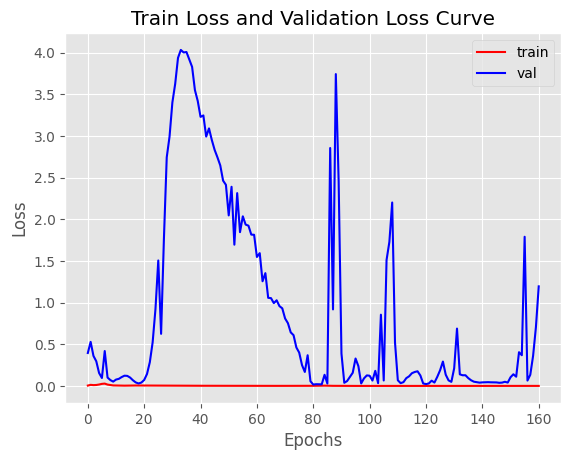

In [66]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [67]:
mse, rmse, mape, r2, true, predicted = evaluate_model_3(model, test, timesteps)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


In [68]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.009244120548516081
RMSE = 0.09614634963697832
MAPE = 0.05267980001025357
R-Squared Score = 0.8887704466101446


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

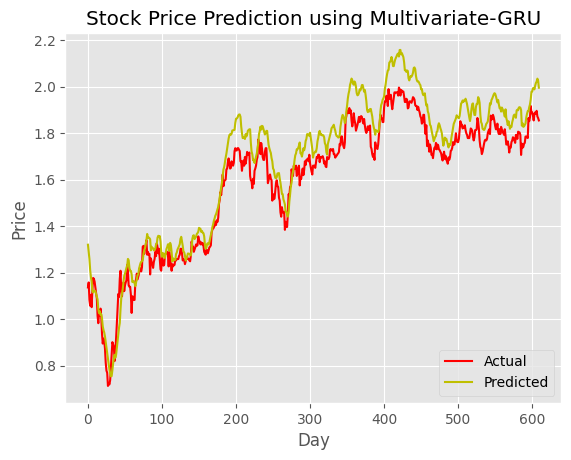

In [69]:
plot_data_3(true, predicted)

In [67]:
# Save a model
model.save('10VAR-hpg-gru.keras')

In [206]:
del model

# Model 3: Multivariate-3-LSTM

## LSTM

### Import các thư viện cần thiết

In [2]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import optimizers

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

In [6]:
plt.style.use('ggplot')

### Hàm callback

In [7]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="10Var_hpg_lstm.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"hpg_history.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [9]:
df.head()

,open,high,low,close,volume
time,,,,,
2007-11-16,2.29,2.29,2.29,2.29,248510
2007-11-19,2.17,2.17,2.17,2.17,120480
2007-11-20,2.08,2.08,2.08,2.08,58710
2007-11-21,1.99,2.16,1.99,2.16,728080
2007-11-22,2.16,2.16,2.08,2.16,266040


In [10]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

### Tiền xử lí dữ liệu

In [11]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [12]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.999667
high      0.999857
low       0.999838
close     1.000000
volume    0.799299
Name: close, dtype: float64

count    4.320000e+03
mean     7.877410e+06
std      1.133795e+07
min      5.000000e+01
25%      4.646300e+05
50%      2.422785e+06
75%      1.233620e+07
max      9.967998e+07
Name: volume, dtype: float64


<Axes: >

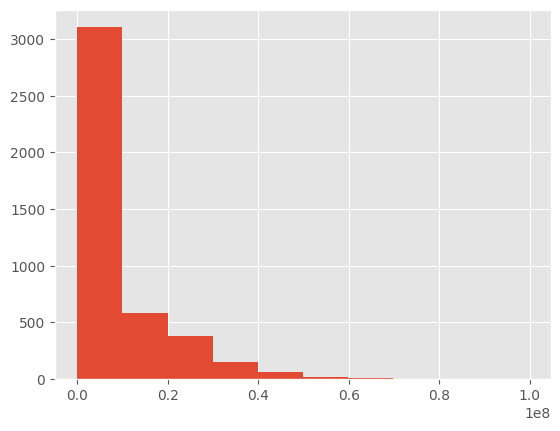

In [13]:
print(df.describe().volume) 
df['volume'].hist(bins= 10)

In [14]:
# Bổ sung các chỉ báo kĩ thuật

# Tính CMA10
df['CMA10'] = df['close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['high'] + df['low'] + df['close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['low'].rolling(window=14).min()
high_max = df['high'].rolling(window=14).max()

df['%K'] = 100 * (df['close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [15]:
print(df.head())
df.shape

            open  high   low  close  volume  CMA10  SMA10  SMA50     EMA12  \
time                                                                         
2007-11-16  2.29  2.29  2.29   2.29  248510    NaN    NaN    NaN  2.290000   
2007-11-19  2.17  2.17  2.17   2.17  120480    NaN    NaN    NaN  2.271538   
2007-11-20  2.08  2.08  2.08   2.08   58710    NaN    NaN    NaN  2.242071   
2007-11-21  1.99  2.16  1.99   2.16  728080    NaN    NaN    NaN  2.229445   
2007-11-22  2.16  2.16  2.08   2.16  266040    NaN    NaN    NaN  2.218761   

               EMA26      MACD  RSI  CCI  %K  %D  
time                                              
2007-11-16  2.290000  0.000000  NaN  NaN NaN NaN  
2007-11-19  2.281111 -0.009573  NaN  NaN NaN NaN  
2007-11-20  2.266214 -0.024143  NaN  NaN NaN NaN  
2007-11-21  2.258346 -0.028902  NaN  NaN NaN NaN  
2007-11-22  2.251061 -0.032300  NaN  NaN NaN NaN  


(4320, 15)

## Train model / Hàm **fit_model_4()**

In [16]:
def fit_model_4(train, val, timesteps, hl, lr, batch, epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Xây dựng mô hình
    model = Sequential()
    model.add(LSTM(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))
    for i in range(len(hl)-1):
        model.add(LSTM(hl[i], activation='relu', return_sequences= True))
    model.add(LSTM(hl[-1], activation='relu'))
    model.add(Dense(1))

    # Biên dịch
    model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')

    # Huấn luyện mô hình
    history = model.fit(X_train, Y_train, batch_size= batch, epochs= epochs, validation_data= (X_val, Y_val), verbose= 0, shuffle= False, callbacks= callbacks_list)

    # Đặt lại trạng thái
    for layer in model.layers:
        if isinstance(layer, LSTM):
            layer.reset_state()

    return model, history.history['loss'], history.history['val_loss']

## Hàm **Evaluate_model_4()**

In [17]:
def evaluate_model_4(model, test, timesteps):
    X_test = []
    Y_test = []

    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Các chỉ số
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)

    return mse, rmse, mape, r2, Y_test, Y_hat

## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [18]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200, 250],  # Số epoch
}

In [19]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_4(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_4(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Plot chart (vẽ biểu đồ)

In [20]:
# Plotting the predictions
def plot_data_4(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual', 'Predicted'], loc = 'lower right')
    plt.show()

In [21]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [22]:
# Extracting the series
series = df[['close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
series.describe()

(4267, 10)


,close,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
count,4267.000000,4267.000000,4267.00000,4267.000000,4267.000000,4267.000000,4267.000000,4267.000000,4267.000000,4267.000000
mean,10.025397,10.022310,9.99800,9.880565,9.992086,52.254060,12.008518,53.007353,53.000609,0.041366
std,10.126221,10.118056,10.10649,10.019039,10.097556,17.992688,112.438235,30.851704,29.031483,0.373255
min,0.680000,0.710000,0.71000,0.793800,0.726093,0.000000,-486.486486,0.000000,0.000000,-1.739242
25%,1.780000,1.778000,1.77800,1.760400,1.776499,38.724730,-76.041990,25.730277,26.681097,-0.045488
50%,5.680000,5.725000,5.70500,5.174200,5.719069,52.577320,21.806854,55.445545,55.238095,0.020672
75%,15.415000,15.376000,15.21950,15.065600,15.178271,66.146301,101.156626,80.702355,79.987975,0.119916
max,39.900000,39.285000,39.28500,37.489200,39.090578,100.000000,364.285714,100.000000,100.000000,2.247325


### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [23]:
series.shape

(4267, 10)

In [24]:

n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)


(2987, 10) (640, 10) (640, 10)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [25]:
np.random.seed(1)
tf.random.set_seed(2)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(2987, 10) (640, 10) (640, 10)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [25]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print(results_df)
print("Best parameters:", best_params)
print("Best RMSE score:", best_score)

Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.34059, saving model to 10Var_hpg_lstm.h5



Epoch 2: val_loss improved from 0.34059 to 0.10461, saving model to 10Var_hpg_lstm.h5



Epoch 3: val_loss did not improve from 0.10461

Epoch 4: val_loss did not improve from 0.10461

Epoch 5: val_loss did not improve from 0.10461

Epoch 6: val_loss did not improve from 0.10461

Epoch 7: val_loss did not improve from 0.10461

Epoch 8: val_loss did not improve from 0.10461

Epoch 9: val_loss did not improve from 0.10461

Epoch 10: val_loss did not improve from 0.10461

Epoch 11: val_loss did not improve from 0.10461

Epoch 12: val_loss did not improve from 0.10461

Epoch 13: val_loss did not improve from 0.10461

Epoch 14: val_loss did not improve from 0.10461

Epoch 15: val_loss did not improve from 0.10461

Epoch 16: val_loss improved from 0.10461 to 0.07478, saving model to 10Var_hpg_lstm.h5



Epoch 17: val_loss improved from 0.07478 to 0.06678, saving model to 10Var_hpg_lstm.h5



Epoch 18: val_loss did not improve from 0.06678

Epoch 19: val_loss did not improve from 0.06678

Epoch 20: val_loss did not improve from 0.06678

Epoch 21: val_loss did not improve from 0.06678

Epoch 22: val_loss did not improve from 0.06678

Epoch 23: val_loss did not improve from 0.06678

Epoch 24: val_loss did not improve from 0.06678

Epoch 25: val_loss did not improve from 0.06678

Epoch 26: val_loss did not improve from 0.06678

Epoch 27: val_loss did not improve from 0.06678

Epoch 28: val_loss did not improve from 0.06678

Epoch 29: val_loss did not improve from 0.06678

Epoch 30: val_loss did not improve from 0.06678

Epoch 31: val_loss did not improve from 0.06678

Epoch 32: val_loss did not improve from 0.06678

Epoch 33: val_loss did not improve from 0.06678

Epoch 34: val_loss did not improve from 0.06678

Epoch 35: val_loss improved from 0.06678 to 0.06629, saving model to 10Var_hpg_lstm.h5



Epoch 36: val_loss did not improve from 0.06629

Epoch 37: val_loss improved from 0.06629 to 0.06588, saving model to 10Var_hpg_lstm.h5



Epoch 38: val_loss did not improve from 0.06588

Epoch 39: val_loss did not improve from 0.06588

Epoch 40: val_loss did not improve from 0.06588

Epoch 41: val_loss did not improve from 0.06588

Epoch 42: val_loss did not improve from 0.06588

Epoch 43: val_loss improved from 0.06588 to 0.06147, saving model to 10Var_hpg_lstm.h5



Epoch 44: val_loss did not improve from 0.06147

Epoch 45: val_loss improved from 0.06147 to 0.04038, saving model to 10Var_hpg_lstm.h5



Epoch 46: val_loss did not improve from 0.04038

Epoch 47: val_loss improved from 0.04038 to 0.03638, saving model to 10Var_hpg_lstm.h5



Epoch 48: val_loss improved from 0.03638 to 0.03284, saving model to 10Var_hpg_lstm.h5



Epoch 49: val_loss improved from 0.03284 to 0.02921, saving model to 10Var_hpg_lstm.h5



Epoch 50: val_loss improved from 0.02921 to 0.02606, saving model to 10Var_hpg_lstm.h5



Epoch 51: val_loss improved from 0.02606 to 0.02315, saving model to 10Var_hpg_lstm.h5



Epoch 52: val_loss improved from 0.02315 to 0.02061, saving model to 10Var_hpg_lstm.h5



Epoch 53: val_loss improved from 0.02061 to 0.01845, saving model to 10Var_hpg_lstm.h5



Epoch 54: val_loss improved from 0.01845 to 0.01664, saving model to 10Var_hpg_lstm.h5



Epoch 55: val_loss improved from 0.01664 to 0.01513, saving model to 10Var_hpg_lstm.h5



Epoch 56: val_loss improved from 0.01513 to 0.01392, saving model to 10Var_hpg_lstm.h5



Epoch 57: val_loss improved from 0.01392 to 0.01295, saving model to 10Var_hpg_lstm.h5



Epoch 58: val_loss improved from 0.01295 to 0.01222, saving model to 10Var_hpg_lstm.h5



Epoch 59: val_loss improved from 0.01222 to 0.01173, saving model to 10Var_hpg_lstm.h5



Epoch 60: val_loss improved from 0.01173 to 0.01145, saving model to 10Var_hpg_lstm.h5



Epoch 61: val_loss improved from 0.01145 to 0.01143, saving model to 10Var_hpg_lstm.h5



Epoch 62: val_loss did not improve from 0.01143

Epoch 63: val_loss did not improve from 0.01143

Epoch 64: val_loss did not improve from 0.01143

Epoch 65: val_loss did not improve from 0.01143

Epoch 66: val_loss did not improve from 0.01143

Epoch 67: val_loss did not improve from 0.01143

Epoch 68: val_loss did not improve from 0.01143

Epoch 69: val_loss did not improve from 0.01143

Epoch 70: val_loss did not improve from 0.01143

Epoch 71: val_loss did not improve from 0.01143

Epoch 72: val_loss did not improve from 0.01143

Epoch 73: val_loss did not improve from 0.01143

Epoch 74: val_loss did not improve from 0.01143

Epoch 75: val_loss did not improve from 0.01143

Epoch 76: val_loss did not improve from 0.01143

Epoch 77: val_loss did not improve from 0.01143

Epoch 78: val_loss did not improve from 0.01143

Epoch 79: val_loss did not improve from 0.01143

Epoch 80: val_loss did not improve from 0.01143

Epoch 81: val_loss did not improve from 0.01143

Epoch 82: val_loss 

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.01143

Epoch 2: val_loss did not improve from 0.01143

Epoch 3: val_loss did not improve from 0.01143

Epoch 4: val_loss did not improve from 0.01143

Epoch 5: val_loss did not improve from 0.01143

Epoch 6: val_loss did not improve from 0.01143

Epoch 7: val_loss did not improve from 0.01143

Epoch 8: val_loss did not improve from 0.01143

Epoch 9: val_loss did not improve from 0.01143

Epoch 10: val_loss did not improve from 0.01143

Epoch 11: val_loss did not improve from 0.01143

Epoch 12: val_loss did not improve from 0.01143

Epoch 13: val_loss did not improve from 0.01143

Epoch 14: val_loss did not improve from 0.01143

Epoch 15: val_loss did not improve from 0.01143

Epoch 16: val_loss did not improve from 0.01143

Epoch 17: val_loss did not improve from 0.01143

Epoch 18: val_loss did not improve from 0.01143

Epoch 19: val_loss did not improve from 0.01143

Epoch 20: val_loss did not improve from 0.01143

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.01143

Epoch 2: val_loss did not improve from 0.01143

Epoch 3: val_loss did not improve from 0.01143

Epoch 4: val_loss did not improve from 0.01143

Epoch 5: val_loss did not improve from 0.01143

Epoch 6: val_loss did not improve from 0.01143

Epoch 7: val_loss did not improve from 0.01143

Epoch 8: val_loss did not improve from 0.01143

Epoch 9: val_loss did not improve from 0.01143

Epoch 10: val_loss did not improve from 0.01143

Epoch 11: val_loss did not improve from 0.01143

Epoch 12: val_loss did not improve from 0.01143

Epoch 13: val_loss did not improve from 0.01143

Epoch 14: val_loss did not improve from 0.01143

Epoch 15: val_loss did not improve from 0.01143

Epoch 16: val_loss did not improve from 0.01143

Epoch 17: val_loss did not improve from 0.01143

Epoch 18: val_loss did not improve from 0.01143

Epoch 19: val_loss did not improve from 0.01143

Epoch 20: val_loss did not improve from 0.01143

Epoch 21: val_loss did not i


Epoch 65: val_loss improved from 0.01082 to 0.00574, saving model to 10Var_hpg_lstm.h5



Epoch 66: val_loss improved from 0.00574 to 0.00485, saving model to 10Var_hpg_lstm.h5



Epoch 67: val_loss did not improve from 0.00485

Epoch 68: val_loss did not improve from 0.00485

Epoch 69: val_loss did not improve from 0.00485

Epoch 70: val_loss did not improve from 0.00485

Epoch 71: val_loss did not improve from 0.00485

Epoch 72: val_loss did not improve from 0.00485

Epoch 73: val_loss did not improve from 0.00485

Epoch 74: val_loss did not improve from 0.00485

Epoch 75: val_loss did not improve from 0.00485

Epoch 76: val_loss did not improve from 0.00485

Epoch 77: val_loss did not improve from 0.00485

Epoch 78: val_loss improved from 0.00485 to 0.00450, saving model to 10Var_hpg_lstm.h5



Epoch 79: val_loss did not improve from 0.00450

Epoch 80: val_loss did not improve from 0.00450

Epoch 81: val_loss did not improve from 0.00450

Epoch 82: val_loss did not improve from 0.00450

Epoch 83: val_loss did not improve from 0.00450

Epoch 84: val_loss did not improve from 0.00450

Epoch 85: val_loss did not improve from 0.00450

Epoch 86: val_loss did not improve from 0.00450

Epoch 87: val_loss did not improve from 0.00450

Epoch 88: val_loss did not improve from 0.00450

Epoch 89: val_loss did not improve from 0.00450

Epoch 90: val_loss did not improve from 0.00450

Epoch 91: val_loss did not improve from 0.00450

Epoch 92: val_loss did not improve from 0.00450

Epoch 93: val_loss did not improve from 0.00450

Epoch 94: val_loss did not improve from 0.00450

Epoch 95: val_loss did not improve from 0.00450

Epoch 96: val_loss did not improve from 0.00450

Epoch 97: val_loss did not improve from 0.00450

Epoch 98: val_loss did not improve from 0.00450

Epoch 99: val_loss 

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00450

Epoch 2: val_loss did not improve from 0.00450

Epoch 3: val_loss did not improve from 0.00450

Epoch 4: val_loss did not improve from 0.00450

Epoch 5: val_loss did not improve from 0.00450

Epoch 6: val_loss did not improve from 0.00450

Epoch 7: val_loss did not improve from 0.00450

Epoch 8: val_loss did not improve from 0.00450

Epoch 9: val_loss did not improve from 0.00450

Epoch 10: val_loss did not improve from 0.00450

Epoch 11: val_loss did not improve from 0.00450

Epoch 12: val_loss did not improve from 0.00450

Epoch 13: val_loss did not improve from 0.00450

Epoch 14: val_loss did not improve from 0.00450

Epoch 15: val_loss did not improve from 0.00450

Epoch 16: val_loss did not improve from 0.00450

Epoch 17: val_loss did not improve from 0.00450

Epoch 18: val_loss did not improve from 0.00450

Epoch 19: val_loss did not improve from 0.00450

Epoch 20: val_loss did not improve from 0.00450

Epoch 21: val_loss did not i

### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [26]:
timesteps = 40
hl = [40, 35]
lr = 1e-3
batch_size = 32
num_epochs = 250

model, train_error, val_error = fit_model_4(train, val, timesteps, hl, lr, batch_size, num_epochs)

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.39539, saving model to 10Var_hpg_lstm.h5



Epoch 2: val_loss did not improve from 0.39539

Epoch 3: val_loss improved from 0.39539 to 0.36036, saving model to 10Var_hpg_lstm.h5



Epoch 4: val_loss improved from 0.36036 to 0.29609, saving model to 10Var_hpg_lstm.h5



Epoch 5: val_loss improved from 0.29609 to 0.15478, saving model to 10Var_hpg_lstm.h5



Epoch 6: val_loss improved from 0.15478 to 0.09551, saving model to 10Var_hpg_lstm.h5



Epoch 7: val_loss did not improve from 0.09551

Epoch 8: val_loss did not improve from 0.09551

Epoch 9: val_loss improved from 0.09551 to 0.07028, saving model to 10Var_hpg_lstm.h5



Epoch 10: val_loss improved from 0.07028 to 0.05181, saving model to 10Var_hpg_lstm.h5



Epoch 11: val_loss did not improve from 0.05181

Epoch 12: val_loss did not improve from 0.05181

Epoch 13: val_loss did not improve from 0.05181

Epoch 14: val_loss did not improve from 0.05181

Epoch 15: val_loss did not improve from 0.05181

Epoch 16: val_loss did not improve from 0.05181

Epoch 17: val_loss did not improve from 0.05181

Epoch 18: val_loss improved from 0.05181 to 0.04220, saving model to 10Var_hpg_lstm.h5



Epoch 19: val_loss improved from 0.04220 to 0.02960, saving model to 10Var_hpg_lstm.h5



Epoch 20: val_loss did not improve from 0.02960

Epoch 21: val_loss did not improve from 0.02960

Epoch 22: val_loss did not improve from 0.02960

Epoch 23: val_loss did not improve from 0.02960

Epoch 24: val_loss did not improve from 0.02960

Epoch 25: val_loss did not improve from 0.02960

Epoch 26: val_loss did not improve from 0.02960

Epoch 27: val_loss did not improve from 0.02960

Epoch 28: val_loss did not improve from 0.02960

Epoch 29: val_loss did not improve from 0.02960

Epoch 30: val_loss did not improve from 0.02960

Epoch 31: val_loss did not improve from 0.02960

Epoch 32: val_loss did not improve from 0.02960

Epoch 33: val_loss did not improve from 0.02960

Epoch 34: val_loss did not improve from 0.02960

Epoch 35: val_loss did not improve from 0.02960

Epoch 36: val_loss did not improve from 0.02960

Epoch 37: val_loss did not improve from 0.02960

Epoch 38: val_loss did not improve from 0.02960

Epoch 39: val_loss did not improve from 0.02960

Epoch 40: val_loss 


Epoch 82: val_loss did not improve from 0.01642

Epoch 83: val_loss did not improve from 0.01642

Epoch 84: val_loss did not improve from 0.01642

Epoch 85: val_loss did not improve from 0.01642

Epoch 86: val_loss did not improve from 0.01642

Epoch 87: val_loss did not improve from 0.01642

Epoch 88: val_loss did not improve from 0.01642

Epoch 89: val_loss did not improve from 0.01642

Epoch 90: val_loss did not improve from 0.01642

Epoch 91: val_loss did not improve from 0.01642

Epoch 92: val_loss did not improve from 0.01642

Epoch 93: val_loss did not improve from 0.01642

Epoch 94: val_loss did not improve from 0.01642

Epoch 95: val_loss did not improve from 0.01642

Epoch 96: val_loss did not improve from 0.01642

Epoch 97: val_loss did not improve from 0.01642

Epoch 98: val_loss did not improve from 0.01642

Epoch 99: val_loss did not improve from 0.01642

Epoch 100: val_loss did not improve from 0.01642

Epoch 101: val_loss did not improve from 0.01642

Epoch 102: val_lo

### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

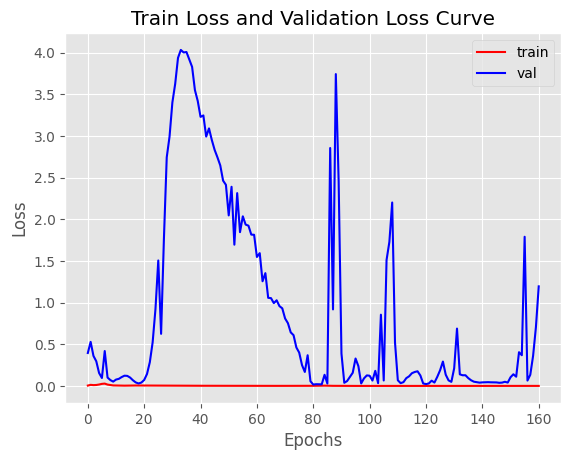

In [27]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [28]:
mse, rmse, mape, r2, true, predicted = evaluate_model_4(model, test, timesteps)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


In [31]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.3025234036292122
RMSE = 0.5500212756150549
MAPE = 0.2892431515809715
R-Squared Score = -2.7453408595001494


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

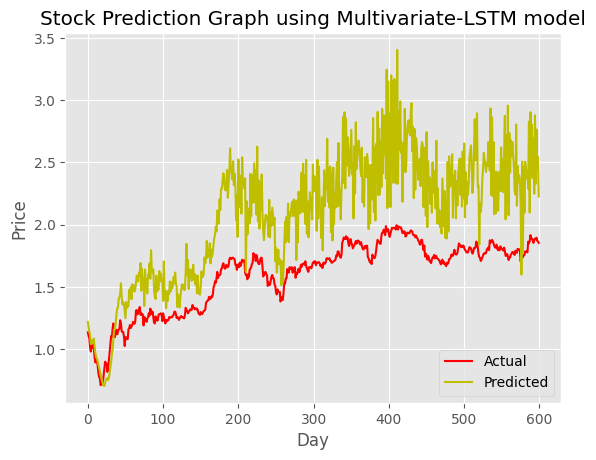

In [32]:
plot_data_4(true, predicted)

In [39]:
# Save a model
model.save('10VAR-hpg-lstm.keras')

In [ ]:
del model